In [2]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import os
import plotly.graph_objects as go

well_loc = pd.read_csv('well-loc.tsv', sep='\t', na_values="-9999")


# Path to the sensor data directory
sensor_data_path = 'sensor-data'

# List all TSV files in the directory
sensor_files = [f for f in os.listdir(sensor_data_path) if f.endswith('.tsv')]

# Load and concatenate all sensor data files into one DataFrame
sensor_data_list = [pd.read_csv(os.path.join(sensor_data_path, file), sep='\t',
                                na_values="-9999") for file in sensor_files]

# Remove the data point with NaN value
well_loc = well_loc.dropna()
for sensor_data in sensor_data_list:
    sensor_data.dropna(inplace=True)


# Reset the index of the well_loc DataFrame to Well, X, Y
well_loc.rename(columns={'井': 'Well'}, inplace=True)

# Reset the index of the sensor data DataFrame to Depth, Porosity, Hydrate Saturation
for idx, _ in enumerate(sensor_data_list):
	sensor_data_list[idx].columns = ['Depth', 'Porosity', 'Hydrate Saturation']



print(well_loc.head())  # Display the first few rows to verify it's loaded correctly
print(sensor_data_list[0].head())  # Display the first few rows to verify it's loaded correctly

  Well      X      Y
0  w01  34500  45000
1  w02  36000  45050
2  w03  37050  45020
3  w04  37880  46000
4  w05  35000  46030
         Depth  Porosity  Hydrate Saturation
352  1640.1288    0.5924           -0.566650
353  1640.2812    0.5916           -0.545652
354  1640.4336    0.5957           -0.567872
355  1640.5860    0.5949           -0.573357
356  1640.7384    0.6058           -0.535303


<Axes: xlabel='X', ylabel='Y'>

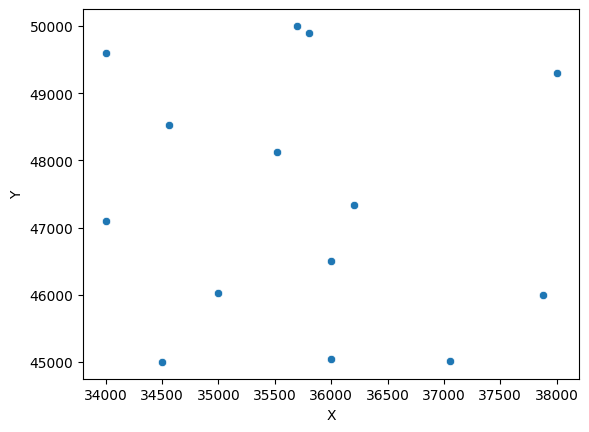

In [3]:
# Plot the well's locations
sns.scatterplot(data=well_loc, x='X', y='Y')

In [4]:
def estimate_resource(sensor_data: pd.Series):
	"""Estimate the resource at a given location based on sensor data"""
	# Get the Porosity and the Hydrate saturation
	porosity = sensor_data['Porosity']
	hydrate_saturation = sensor_data['Hydrate Saturation']

	valid_volume = 1 # Assume the valid volume is 1 cubic meter
	factor = 155 # Assume the factor is 155

	# Calculate the resource estimate
	return valid_volume * porosity * hydrate_saturation * factor

In [5]:
esti_data_list = []

# Calculate the resource estimate for each sensor data in each depth
for sensor_data in sensor_data_list:
	estimation = pd.DataFrame()
	estimation['Estimated Resources'] = sensor_data.apply(estimate_resource, axis=1)
	estimation['Depth'] = sensor_data['Depth']
	esti_data_list.append(estimation)

print(esti_data_list[0].head())  # Display the first few rows to verify the resource estimate is calculated correctly

     Estimated Resources      Depth
352           -52.030927  1640.1288
353           -50.035170  1640.2812
354           -52.433572  1640.4336
355           -52.868953  1640.5860
356           -50.264416  1640.7384


In [8]:
# Create a 3D scatter plot
fig = go.Figure()

for idx, df in enumerate(esti_data_list):
    well_name = well_loc.iloc[idx]['Well']
    x_coord = well_loc.iloc[idx]['X']
    y_coord = well_loc.iloc[idx]['Y']
    
    fig.add_trace(go.Scatter3d(
        x=[x_coord] * len(df),  # Repeat the X coordinate for each depth
        y=[y_coord] * len(df),  # Repeat the Y coordinate for each depth
        z=df['Depth'],
        mode='markers',
        marker=dict(
            size=3,
            color=df['Estimated Resources'],  # Color points by estimated resources
            colorscale='Viridis',
            opacity=0.8
        ),
        name=f'Well {well_name}'
    ))

# Update plot layout
fig.update_layout(
    title='3D Plot of Resource Distribution by Depth',
    scene=dict(
        xaxis_title='X Coordinate',
        yaxis_title='Y Coordinate',
        zaxis_title='Depth'
    ),
    legend_title="Well ID"
)

fig.show()